# GeoJSON States Data Reduction with K-Means

## Import Libraries

In [1]:
import numpy as np
import scipy as sp
import sklearn.cluster as clt
import matplotlib.pyplot as plt

## Problem Understanding & Intuitive Idea

#### At CLUES_NoteBook file we wanted to plot a geographical map with the federal boundaries of México but it delays 10 seconds to show the original information. Therefore, we must reduce our data to speed up our DashBoard while keeping chiefly morphological information. To conceive a better understanding about our problem let's set up an example.

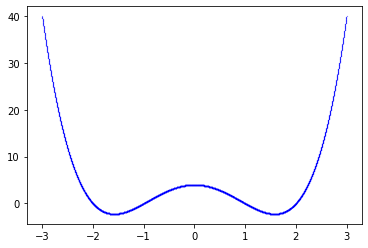

In [2]:
x = np.linspace(-3,3,10000);
y = x**4 - 5*x**2 + 4;

plt.plot(x,y, "bo", markersize=0.1)

#### We want to reduce the necessary quantity of points to draw the function "y" (10,000 points) without losing essential morphological information. Let's suppose we'll reduce this data to 1% of its total

In [3]:
clusters = int(x.size * 0.01)

print(x.size)
print(clusters)

10000
100


In [4]:
data = np.array([x,y]).T
data

array([[-3.        , 40.        ],
       [-2.99939994, 39.95321296],
       [-2.99879988, 39.90646119],
       ...,
       [ 2.99879988, 39.90646119],
       [ 2.99939994, 39.95321296],
       [ 3.        , 40.        ]])

#### We proceed to generate the K-means algorithm. We set the number of clusters, a select initial centroids at random from data, a maximum number of iterations and number of times the algorithm will choose different initial centroids. 

In [5]:
kmCirculo = clt.KMeans(n_clusters=clusters, init="random", 
                       n_init=10, max_iter=300).fit(data)

#### As it can be seen in the following section, the reduced data could keep morphological information from the original dataset with few points (100 out of 10,000)

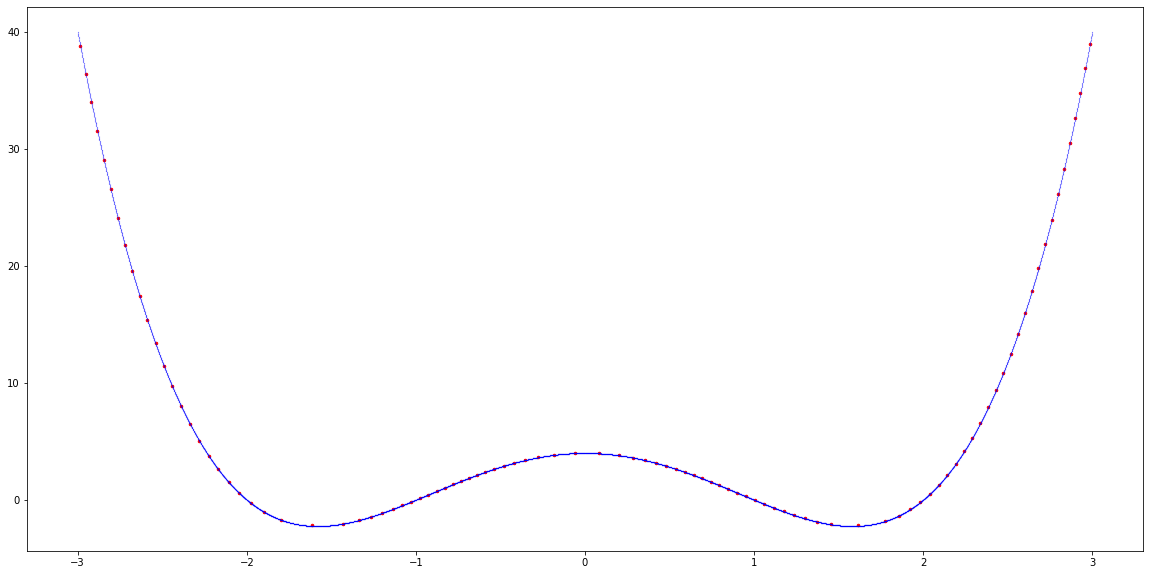

In [6]:
data2 = kmCirculo.cluster_centers_
plt.figure(figsize=(20,10))
plt.plot(data2.T[0], data2.T[1], "ro", markersize=5)
plt.plot(x,y, "bo", markersize=0.1)

## GeoJSON Data

In [7]:
import json as js
import urllib.request

EstadosLink = "https://www.gits.igg.unam.mx/repositoriodecapas/geojson/u_territorial_estados_mgn_inegi_2013.json"

with urllib.request.urlopen(EstadosLink) as url:
    jsEstados = js.loads(url.read().decode())

jsEstados.keys()

dict_keys(['type', 'totalFeatures', 'features', 'crs'])

In [8]:
jsEstados["features"][0]["geometry"]["coordinates"][0][0][0:10]

[[-102.28786518177598, 22.4164900394176],
 [-102.28752816465047, 22.416076588926618],
 [-102.28698945638217, 22.416125260116193],
 [-102.28669938117298, 22.41638747049316],
 [-102.28646481152327, 22.416655105912255],
 [-102.28625342073138, 22.416896294842616],
 [-102.28583380584078, 22.417119735701906],
 [-102.28571714190554, 22.417119951835797],
 [-102.28556460480813, 22.41712023429595],
 [-102.28543057841773, 22.41712048235449]]

#### We proceed to assign boundary coordinates of "Aguascalientes" state to variable "Aguas" and plot it. 

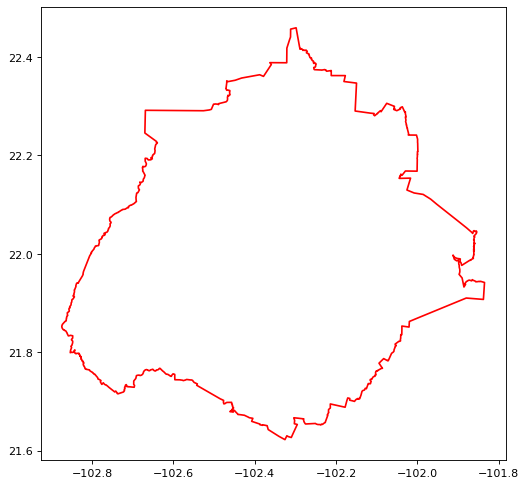

In [9]:
Aguas = np.array(jsEstados["features"][0]["geometry"]["coordinates"][0][0]).T

plt.figure(figsize=(7.5, 7.5), dpi=80)
plt.plot(Aguas[0], Aguas[1], "r")

#### We set 33% of centroids from its total.

In [10]:
clusters = int(Aguas.shape[1] * 0.33)
print("Clusters: {} | Original: {}".format(clusters,Aguas.shape[1]))

Clusters: 794 | Original: 2409


#### Next, set an index to select evenly spaced values from original dataset. 

In [11]:
index = np.arange(0, Aguas.shape[1]-1, 
                  (Aguas.shape[1]-1)/clusters,
                  dtype=int)

index[0:10]

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27])

In [12]:
kmEstado = clt.KMeans(n_clusters=clusters, init=Aguas.T[index], 
                      n_init=1, max_iter=1).fit(Aguas.T)

In [13]:
dataEstado = kmEstado.cluster_centers_
dataEstado[-1] = dataEstado[0]
dataEstado[[-1,0]]

array([[-102.28951693,   22.42060177],
       [-102.28951693,   22.42060177]])

#### We can see in the following plot that K-means algorithm is capable of generalize smoothly boundaries instead of Index technique.

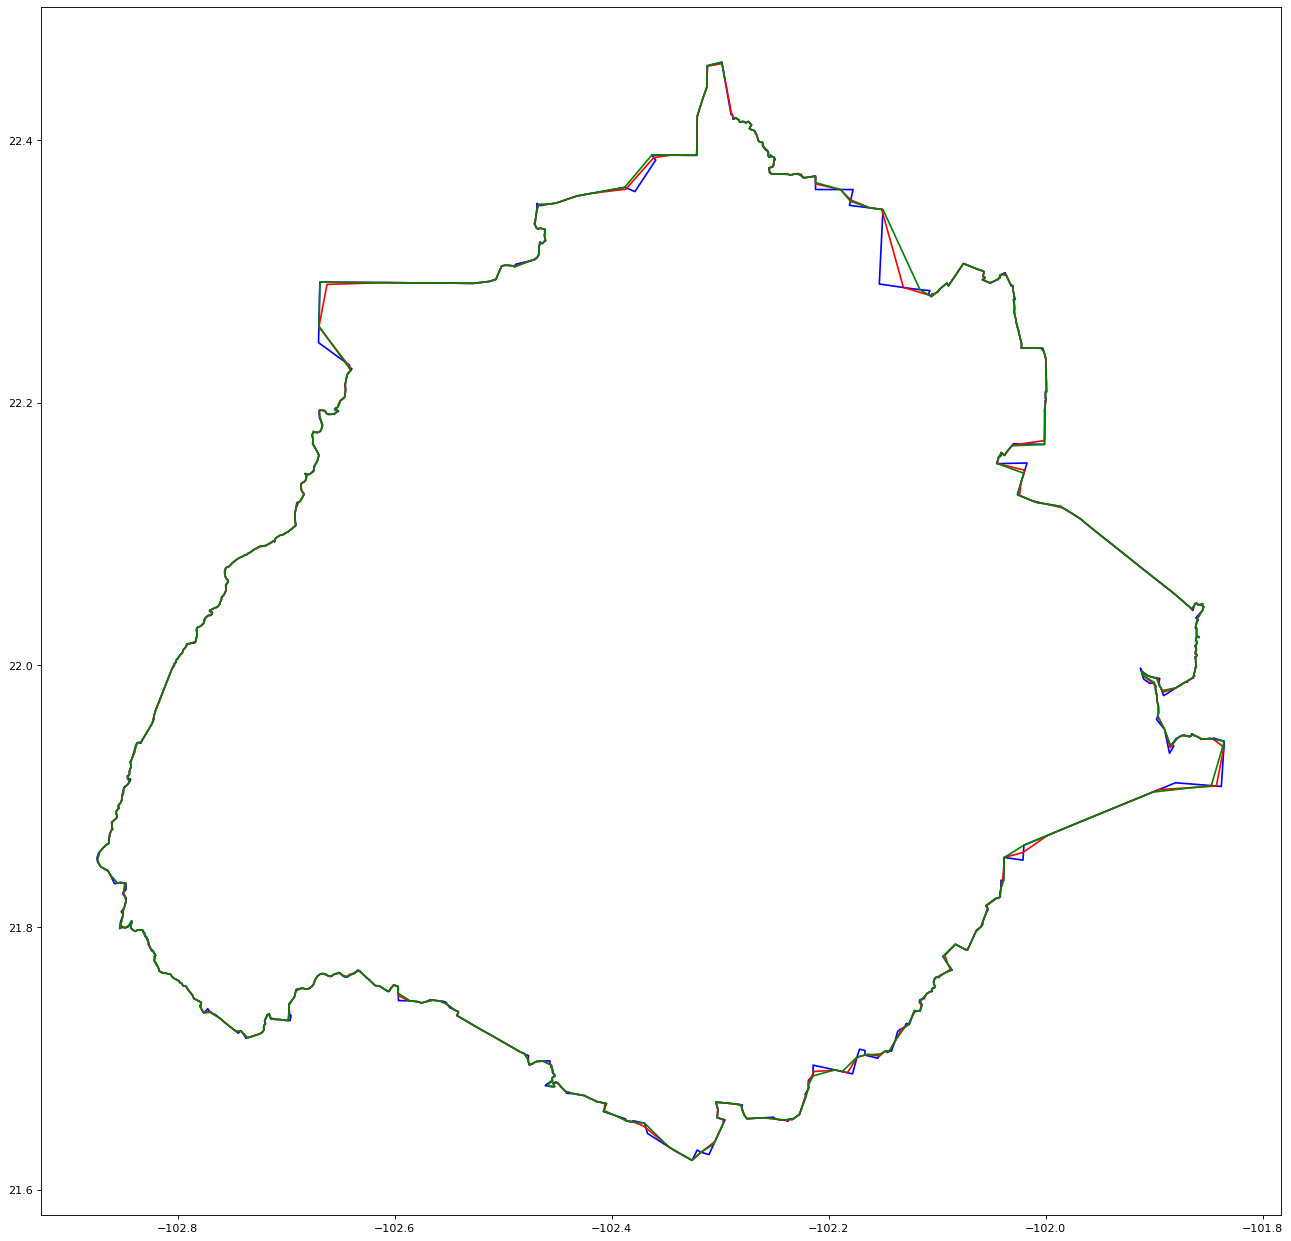

In [14]:
plt.figure(figsize=(20, 20), dpi=80)

plt.plot(Aguas[0], Aguas[1], "b")
plt.plot(dataEstado.T[0], dataEstado.T[1], "r-",markersize=5)
plt.plot(Aguas[0][index], Aguas[1][index], "g-",markersize=5)

## New index as a function of coordinates closeness

#### We proceed to generate probability mass function (PMF) as a function of closeness among coordinates. The most distant a point is, the most probability to be a centroid it'll get. 

<Figure size 800x800 with 0 Axes>

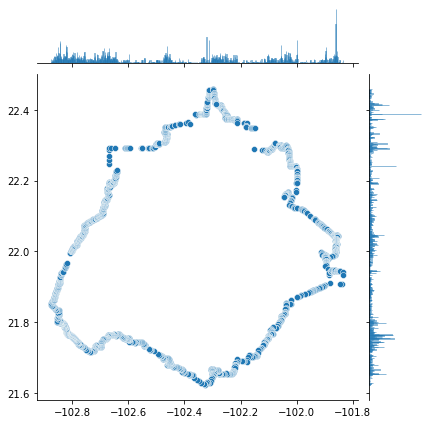

In [15]:
import seaborn as sns 

plt.figure(figsize=(10, 10), dpi=80)

sns.jointplot(x=Aguas[0], y=Aguas[1], marginal_kws=dict(bins=1000, fill=False))
#g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

In [16]:
Anterior = np.insert(Aguas.T, 0, Aguas.T[-1], axis=0)
Anterior = np.delete(Anterior, len(Anterior)-1, axis = 0)
Anterior

array([[-102.28786518,   22.41649004],
       [-102.28786518,   22.41649004],
       [-102.28752816,   22.41607659],
       ...,
       [-102.2881014 ,   22.41728016],
       [-102.28786518,   22.41649004],
       [-102.28786518,   22.41649004]])

In [17]:
Posterior = np.insert(Aguas.T, -1, Aguas.T[0], axis=0)
Posterior = np.delete(Posterior, 0, axis = 0)
Posterior

array([[-102.28752816,   22.41607659],
       [-102.28698946,   22.41612526],
       [-102.28669938,   22.41638747],
       ...,
       [-102.28786518,   22.41649004],
       [-102.28786518,   22.41649004],
       [-102.28786518,   22.41649004]])

#### Our PMF is correct only if added altogether gave us 1.

In [18]:
Va = (Aguas.T - Anterior)
Vp = (Aguas.T - Posterior)

Ca = np.sqrt((Va[:,0])**2 + (Va[:,1])**2)
Cp = np.sqrt((Vp[:,0])**2 + (Vp[:,1])**2)

Dens = Ca*Cp

Dens /= np.sum(Dens)

Dens.sum()

1.0

#### We set 25% of centroids from total dataframe.

In [19]:
clusters = int(Aguas.shape[1] * 0.25)
clusters

602

#### Now, we join our previous code and generate the data reduction.

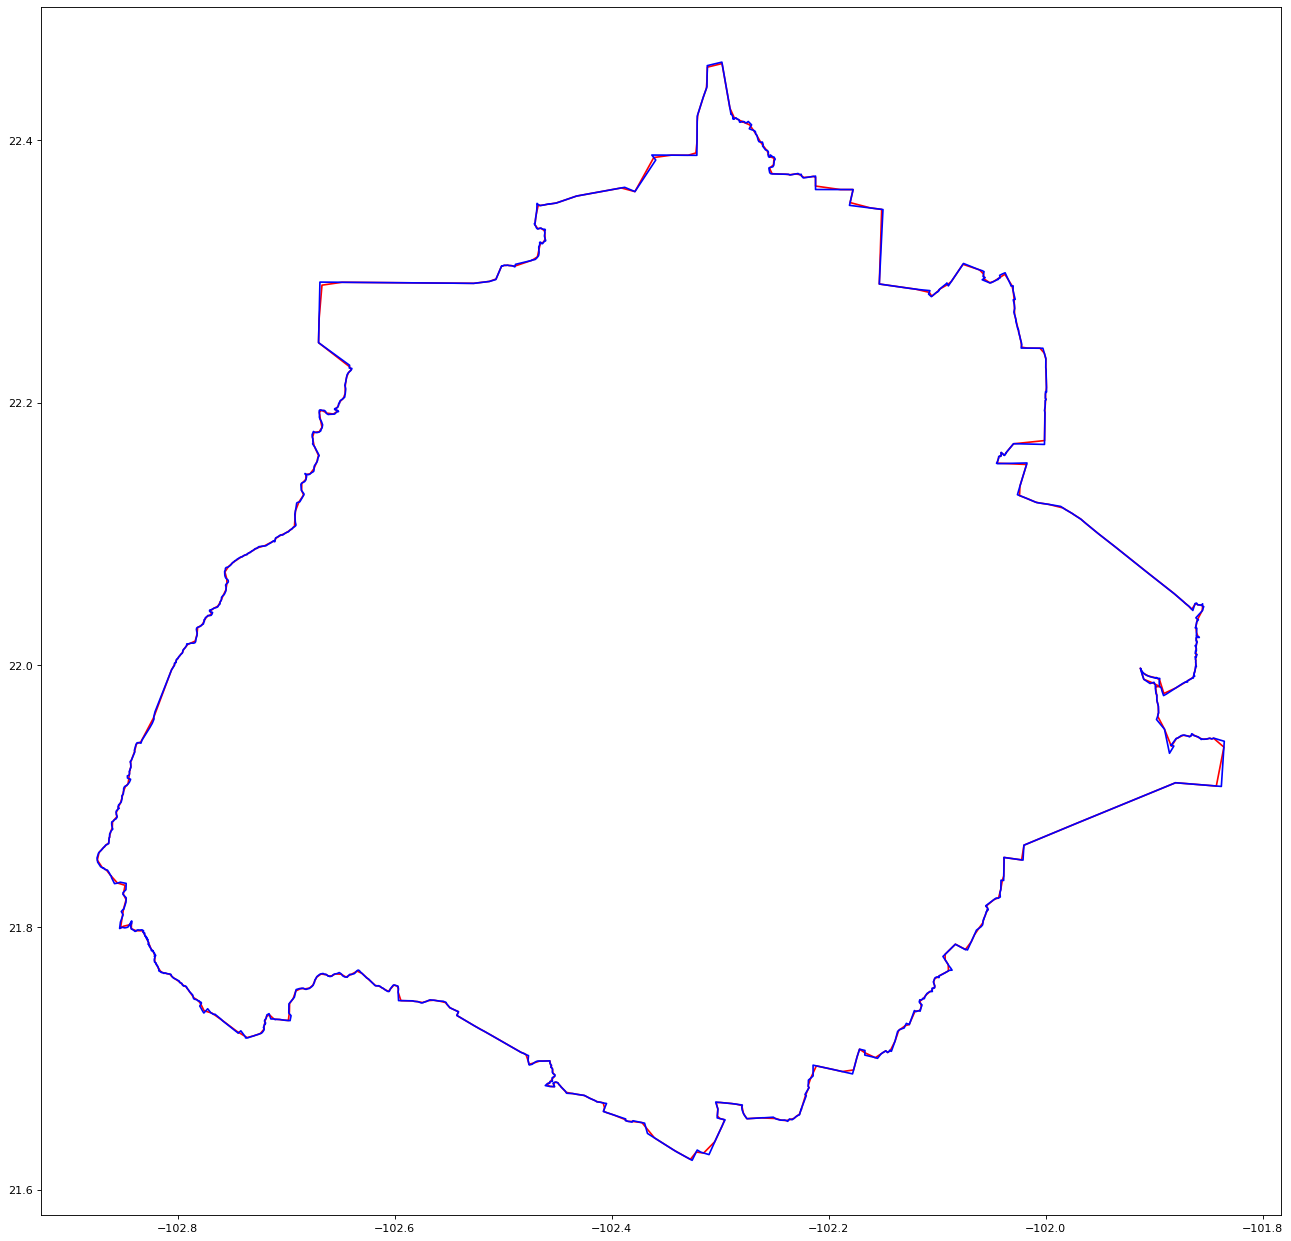

In [20]:
iterations = 50
index4 = np.zeros(shape = (clusters))

dataEstado2 = np.zeros(shape = (clusters,2))

# We make this loop to get an average index from n iterations.
for i in range(iterations):
    index4 += np.sort(np.random.choice(Aguas.shape[1], clusters, replace=False, p=Dens))

index4 = np.around(index4 / iterations).astype("int32")

kmEstado2 = clt.KMeans(n_clusters=clusters, init=Aguas.T[index4],
                       n_init=1, max_iter=100).fit(Aguas.T)

dataEstado2 = kmEstado2.cluster_centers_ 

dataEstado2 = np.vstack((dataEstado2,dataEstado2[0]))
dataEstado2[-1] = dataEstado2[0]

plt.figure(figsize=(20, 20), dpi=80)

plt.plot(dataEstado2.T[0], dataEstado2.T[1],"r")
plt.plot(Aguas[0], Aguas[1], "b")
#plt.plot(Aguas.T[index4].T[0], Aguas.T[index4].T[1], "g")

#### We can make slightly changes in our code to get smoother boundaries 

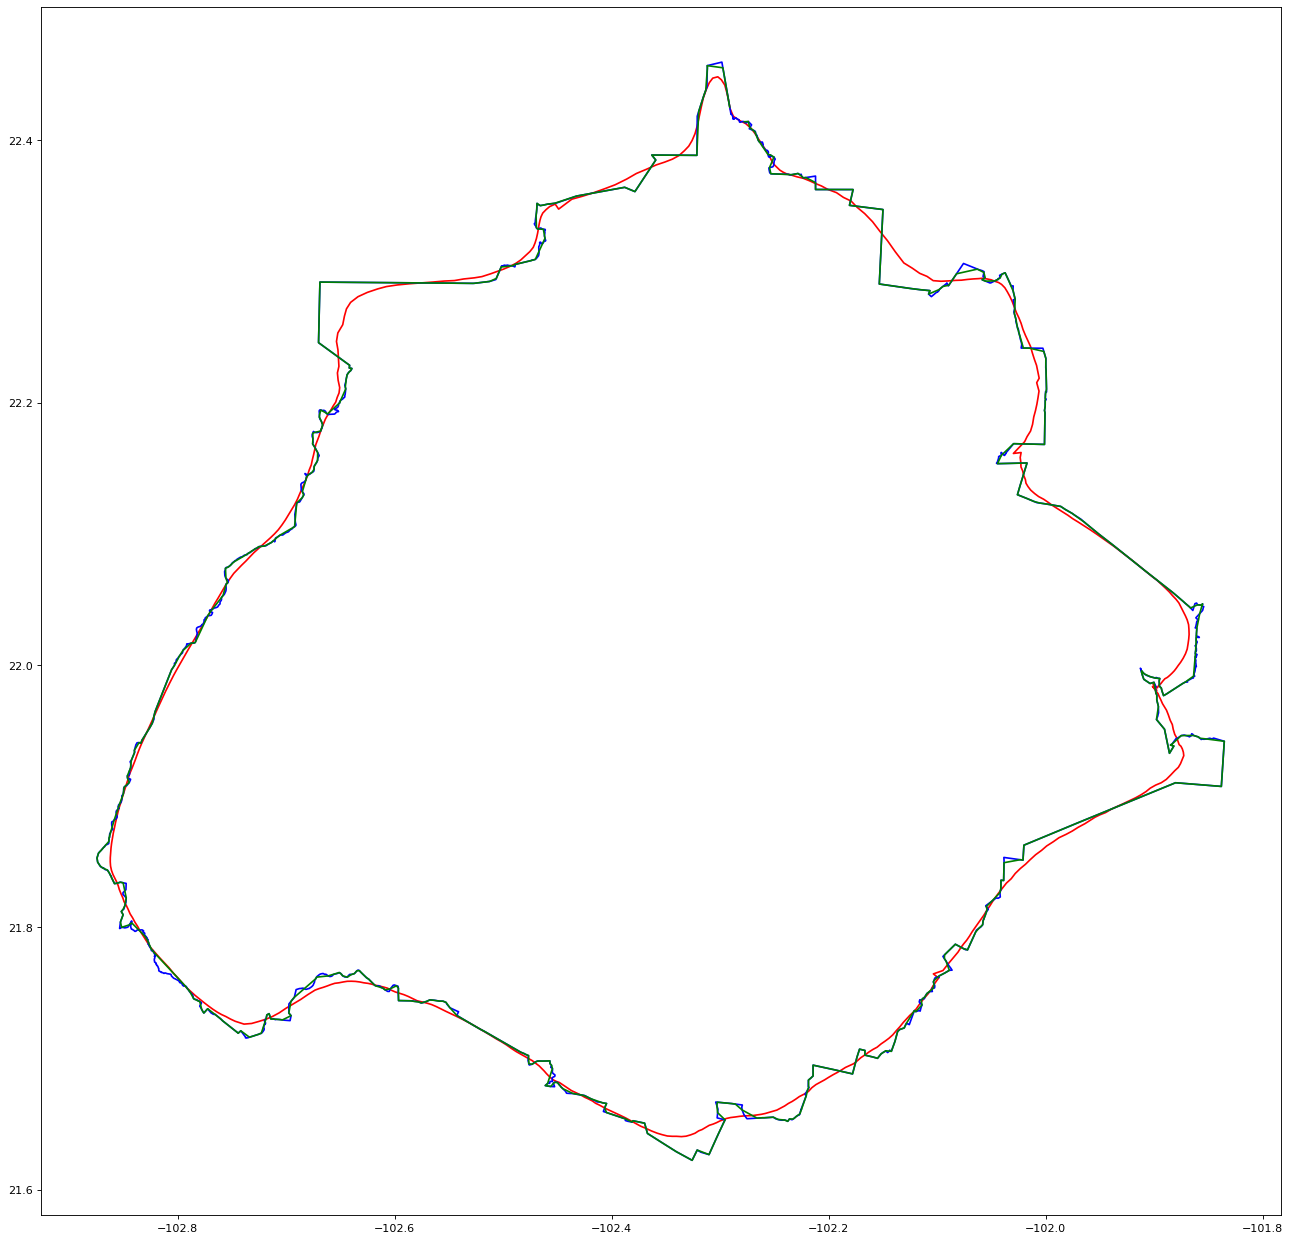

In [21]:
iterations = 100
index4 = [0,] * clusters

dataEstado2 = np.zeros(shape = (clusters,2))

for i in range(iterations):
    index4 = sorted(np.random.choice(Aguas.shape[1], clusters, replace=False, p=Dens))
    
    kmEstado2 = clt.KMeans(n_clusters=clusters, init=Aguas.T[index4],
                       n_init=1, max_iter=100).fit(Aguas.T)

    dataEstado2 += kmEstado2.cluster_centers_

dataEstado2 /= iterations

dataEstado2 = np.vstack((dataEstado2,dataEstado2[0]))
dataEstado2[-1] = dataEstado2[0]

plt.figure(figsize=(20, 20), dpi=80)

plt.plot(dataEstado2.T[0], dataEstado2.T[1],"r")
plt.plot(Aguas[0], Aguas[1], "b")
plt.plot(Aguas.T[index4].T[0], Aguas.T[index4].T[1], "g")

#### Or get boundaries not averaged

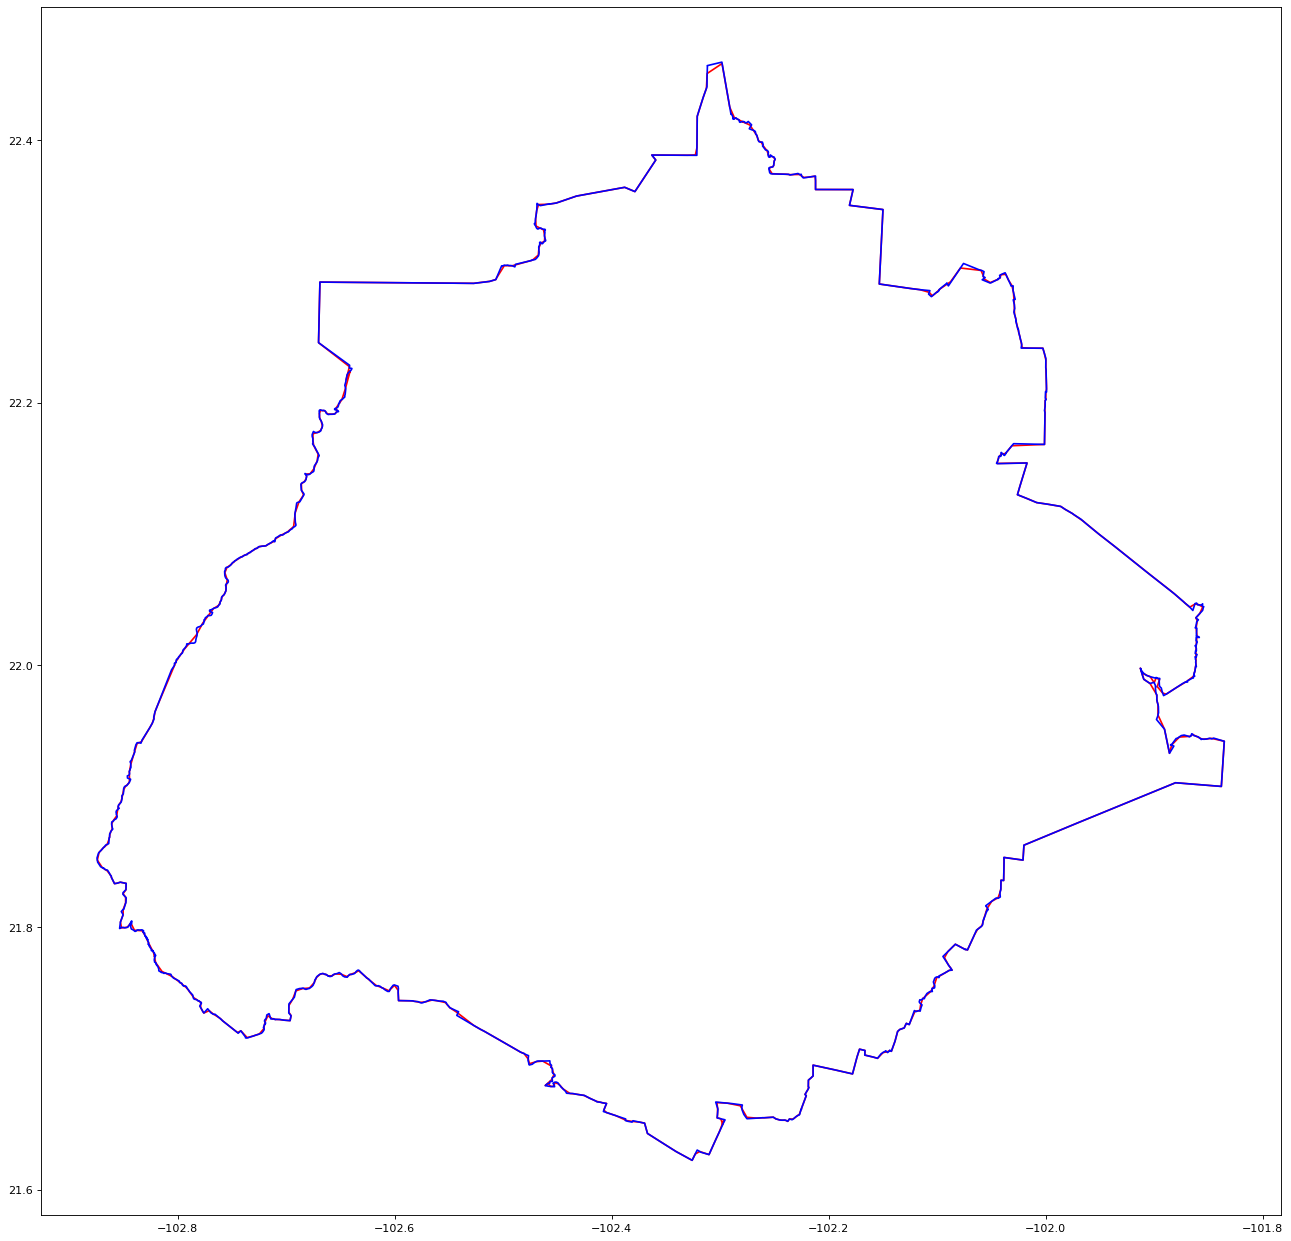

In [22]:
clusters = int(Aguas.shape[1] * 0.25)

index4 = np.sort(np.random.choice(Aguas.shape[1], clusters, replace=False, p=Dens))

kmEstado2 = clt.KMeans(n_clusters=clusters, init=Aguas.T[index4],
                      n_init=1, max_iter=10).fit(Aguas.T)

dataEstado2 = kmEstado2.cluster_centers_
dataEstado2 = np.vstack((dataEstado2,dataEstado2[0]))
dataEstado2[-1] = dataEstado2[0]

plt.figure(figsize=(20, 20), dpi=80)

plt.plot(dataEstado2.T[0], dataEstado2.T[1],"r")
plt.plot(Aguas[0], Aguas[1], "b")
#plt.plot(Aguas.T[index4].T[0], Aguas.T[index4].T[1], "g")

## Algorithm without conditional stopping

In [23]:
EstadosLink = "https://www.gits.igg.unam.mx/repositoriodecapas/geojson/u_territorial_estados_mgn_inegi_2013.json"

with urllib.request.urlopen(EstadosLink) as url:
    jsEstados = js.loads(url.read().decode())
    
with urllib.request.urlopen(EstadosLink) as url:
    jsEstados2 = js.loads(url.read().decode())
    

In [24]:
def selectDivision(divisiones):
    if len(divisiones) > 1:
        
        puntos = 0
        posicion = 0
        
        for j in range(len(divisiones)):
            cantidadP = len(divisiones[j][0])
            
            if cantidadP > puntos:
                #print("Estado: {} | CantidadP: {} | Punto: {}".format(i,cantidadP,punto))
                puntos = len(divisiones[j][0])
                posicion = j
    else:
        posicion = 0
        puntos = len(divisiones[0][0])
        
    return posicion, puntos

In [25]:
def PMF_puntos2(array):
    Anterior = np.insert(array.T, 0, array.T[-1], axis=0)
    Anterior = np.delete(Anterior, len(Anterior)-1, axis = 0)
    
    Posterior = np.insert(array.T, -1, array.T[0], axis=0)
    Posterior = np.delete(Posterior, 0, axis = 0)
    
    B1 = (Anterior - array.T)
    B2 = (Posterior - array.T)
    
    total = (abs(B1 + B2)/2) #abs

    Dens = total.T[0] * total.T[1]

    Dens = Dens / sum(Dens)
    
    return Dens

In [26]:
def PMF_puntos(array):
    Anterior = np.insert(array.T, 0, array.T[-1], axis=0)
    Anterior = np.delete(Anterior, len(Anterior)-1, axis = 0)
    
    Posterior = np.insert(array.T, len(array.T), array.T[0], axis=0)
    Posterior = np.delete(Posterior, 0, axis = 0)
    
    Va = (array.T - Anterior)
    Vp = (array.T - Posterior)
    
    Ca = np.sqrt((Va[:,0])**2 + (Va[:,1])**2)
    Cp = np.sqrt((Vp[:,0])**2 + (Vp[:,1])**2)
    
    Dens = Ca*Cp
    
    Dens /= np.sum(Dens)
    #Dens = np.around(Dens, decimals=10)
    
    return Dens

In [27]:
def promPMF(array, clusters, iterations, PMF):
    iterations = iterations
    index = np.zeros(shape = (clusters))

    #dataEstado = np.zeros(shape = (clusters,2))

    for i in range(iterations):
        index += np.sort(np.random.choice(array.shape[1], clusters, replace=False, p=PMF))

    index = np.around(index / iterations).astype("int32")
    
    return index


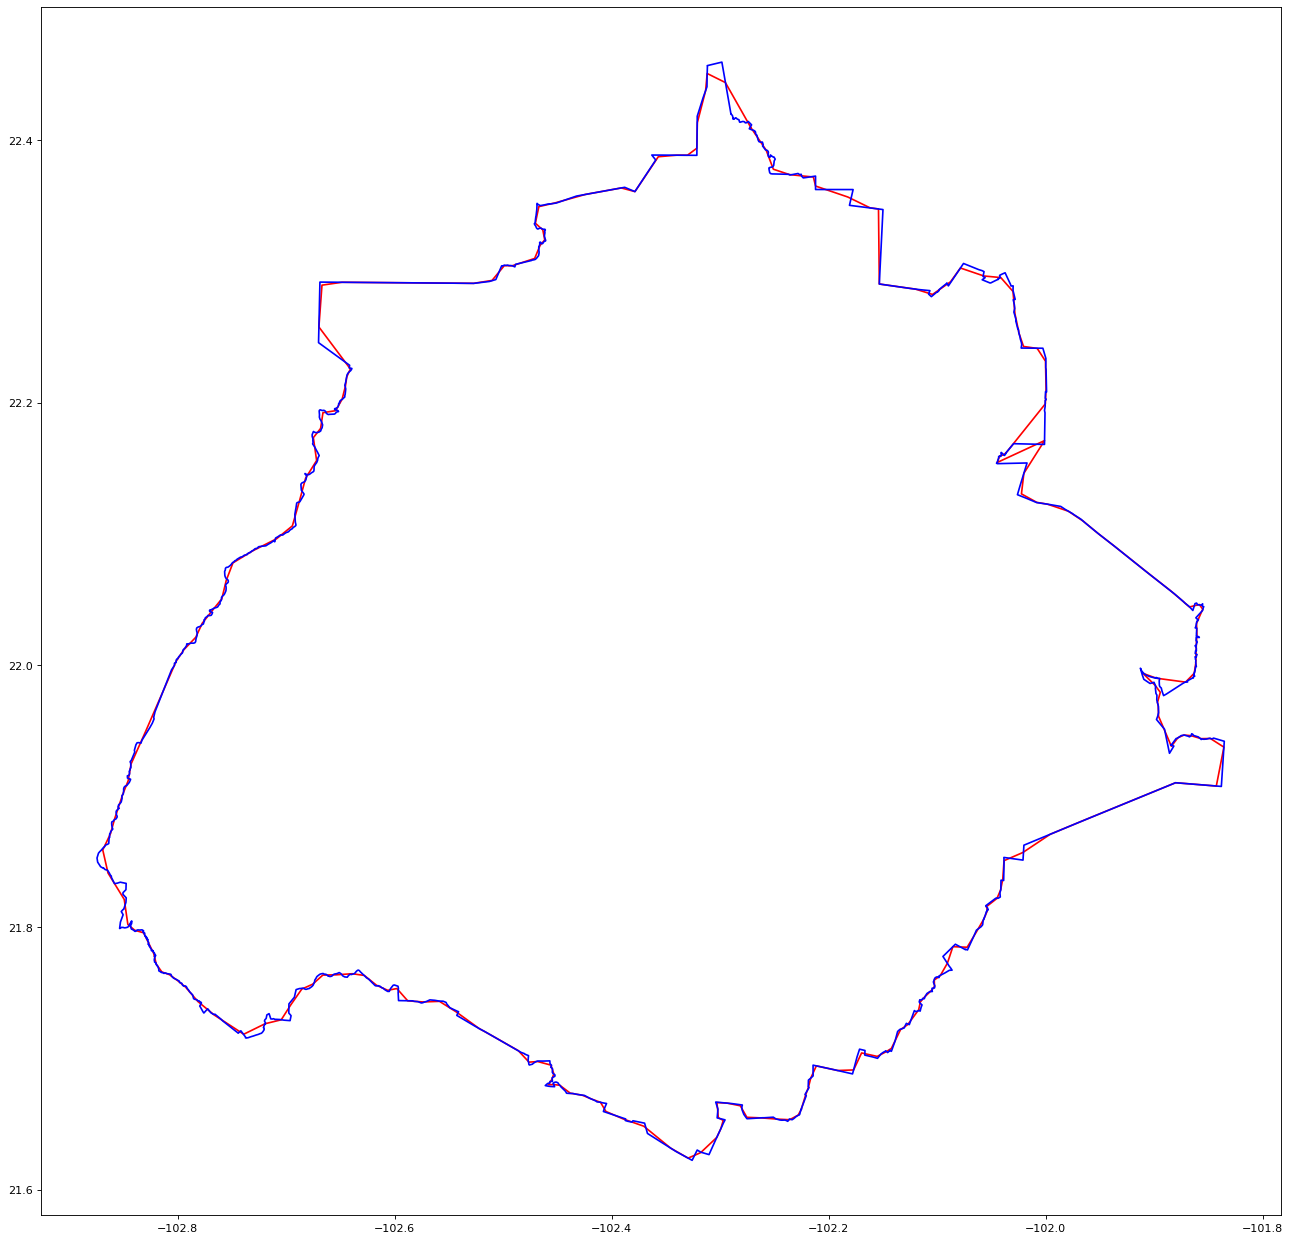

In [28]:
import numpy as np
import sklearn.cluster as clt
import matplotlib.pyplot as plt

entidades = len(jsEstados["features"])
divisiones = np.zeros(shape = (entidades))

i = 0
    
divisiones = jsEstados["features"][i]["geometry"]["coordinates"]

posDiv, cantPunt = selectDivision(divisiones)

Estado = np.array(divisiones[posDiv][0]).T
Estado = np.unique(Estado, axis=0)

PMF = PMF_puntos(Estado)
clusters = int(Estado.shape[1] * 0.1) #0.25

cost = 100

index = promPMF(Estado, clusters, round(Estado[1].size * 0.10), PMF) 

kmEstado = clt.KMeans(n_clusters=clusters, init=Estado.T[index],
                      n_init=1, max_iter=50).fit(Estado.T)

dataEstado = kmEstado.cluster_centers_ 

dataEstado[-1] = dataEstado[0]

jsEstados2["features"][i]["geometry"]["coordinates"] = [[dataEstado.tolist()]]

plt.figure(figsize=(20, 20), dpi=80)
plt.plot(dataEstado.T[0], dataEstado.T[1],"r")
plt.plot(Estado[0], Estado[1], "b")

### Cost Function Formulation

#### We need to calculate the difference between original and simplified data (error). In case we get high error, we should repeat the process for that entity. First of all we have to standardize both datasets (original and reduced). Coordinates form original data must be selected as a function of the index applied to initial centroids. If final centroids drastically moved away from original ones, it'd be a solid prove for repeat the algorithm until we get an acceptable one.

In [29]:
# Standardization
dataEstadoNorm = dataEstado.T[1] / dataEstado.T[1].max()
EstadoNorm = Estado.T[index].T[1] / Estado.T[index].T[1].max()

In [30]:
# Normalization
dataEstadoNorm = (dataEstado.T[1] - dataEstado.T[1].mean()) / dataEstado.T[1].std()
EstadoNorm = (Estado.T[index].T[1] - Estado.T[index].T[1].mean())/ Estado.T[index].T[1].std()

In [31]:
# Standardization 2
dataEstadoNorm = (dataEstado.T[1] - dataEstado.T[1].min()) / (dataEstado.T[1] - dataEstado.T[1].min()).max()
EstadoNorm = (Estado.T[index].T[1] - Estado.T[index].T[1].min()) / (Estado.T[index].T[1] - Estado.T[index].T[1].min()).max()

dataEstadoNorm *= 100
EstadoNorm *= 100

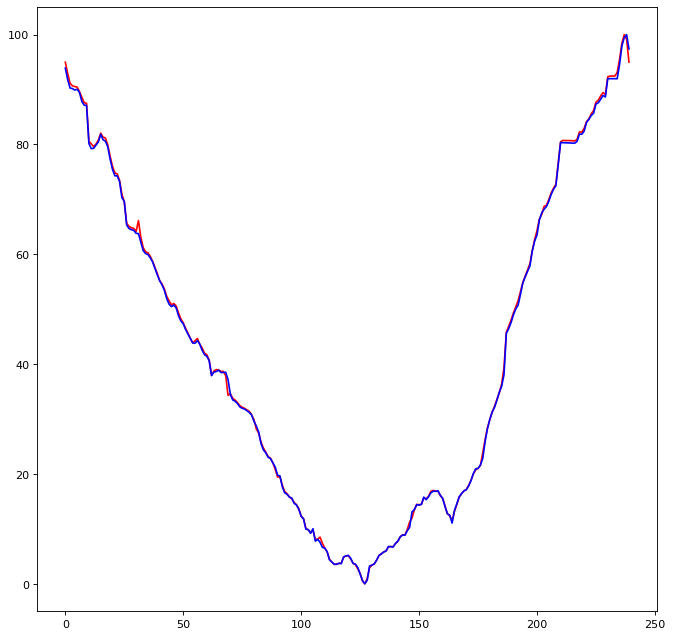

In [32]:
plt.figure(figsize=(10, 10), dpi=80)

#plt.plot(dataEstado.T[1], "or", markersize=1)
#plt.plot(Estado.T[index].T[1], "ob", markersize=1)

plt.plot(dataEstadoNorm, c="r")
plt.plot(EstadoNorm, c="b")

In [33]:
Dif = ((EstadoNorm - dataEstadoNorm) ** 2).sum()
Dif

53.20992031545656

## Algorithm with conditional stopping

#### We proceed to reduce all states federal boundaries using our PMF, cost function and conditional stopping.

In [34]:
def Cost_Func(observed, expected):
    dif_Ob = observed - observed.min()
    dif_Exp = expected - expected.min()
    
    dataEstadoNorm = (dif_Ob) / (dif_Ob).max()
    EstadoNorm = (dif_Exp) / (dif_Exp).max()
    
    dataEstadoNorm *= 100
    EstadoNorm *= 100
    
    Cost = ((EstadoNorm - dataEstadoNorm) ** 2).sum()
    
    return Cost

In [35]:
EstadosLink = "https://www.gits.igg.unam.mx/repositoriodecapas/geojson/u_territorial_estados_mgn_inegi_2013.json"

with urllib.request.urlopen(EstadosLink) as url:
    jsEstados = js.loads(url.read().decode())
    
with urllib.request.urlopen(EstadosLink) as url:
    jsEstados2 = js.loads(url.read().decode())
    

Clusters: 266 | %: 0.11081517653848255
0 : Cost:  33.232430871474335  | Límite:  33.0
0 : Cost:  36.21340526822695  | Límite:  33.0
0 : Cost:  29.564123273197605  | Límite:  33.0
29.564123273197605
No pasé por memCost


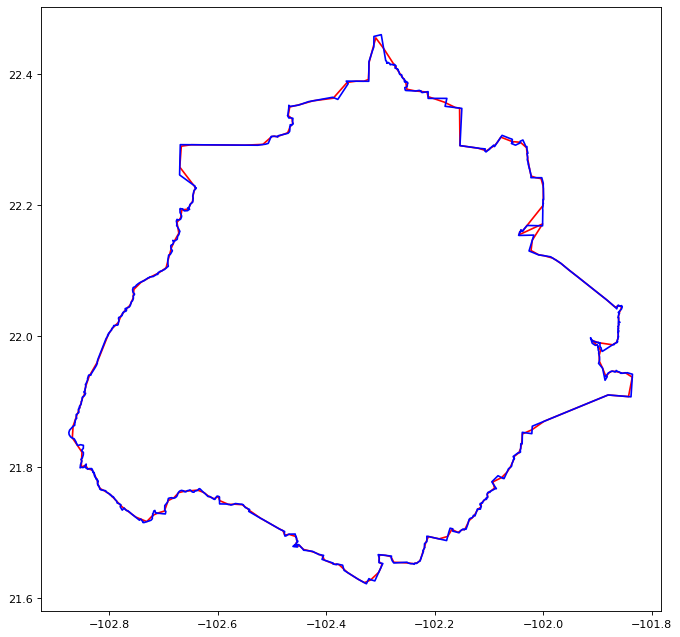

Clusters: 916 | %: 0.049561470989459545
1 : Cost:  7.150636394173457  | Límite:  81.0
7.150636394173457
No pasé por memCost


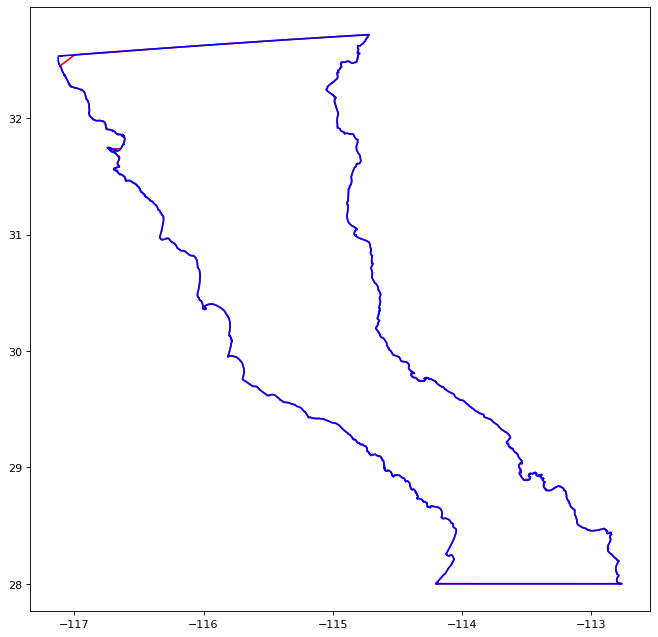

Clusters: 876 | %: 0.032624506441622715
2 : Cost:  9.841878955590643  | Límite:  96.0
9.841878955590643
No pasé por memCost


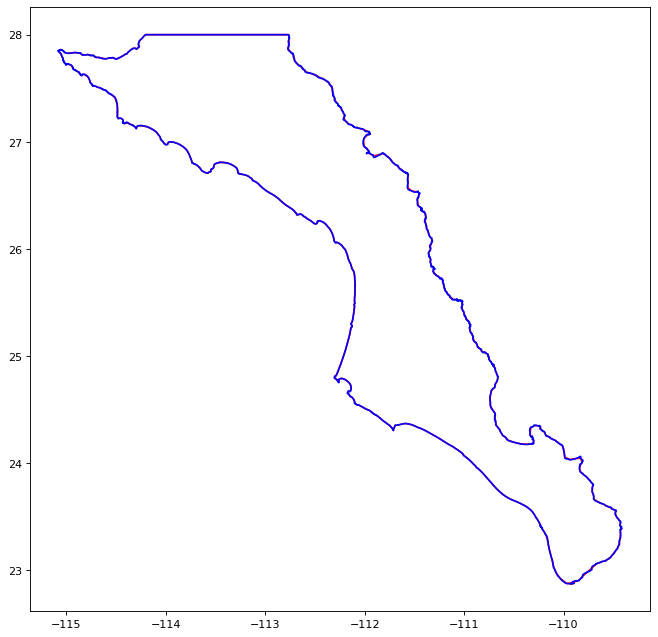

Clusters: 740 | %: 0.07756480164995022
3 : Cost:  24.810484412106206  | Límite:  60.0
24.810484412106206
No pasé por memCost


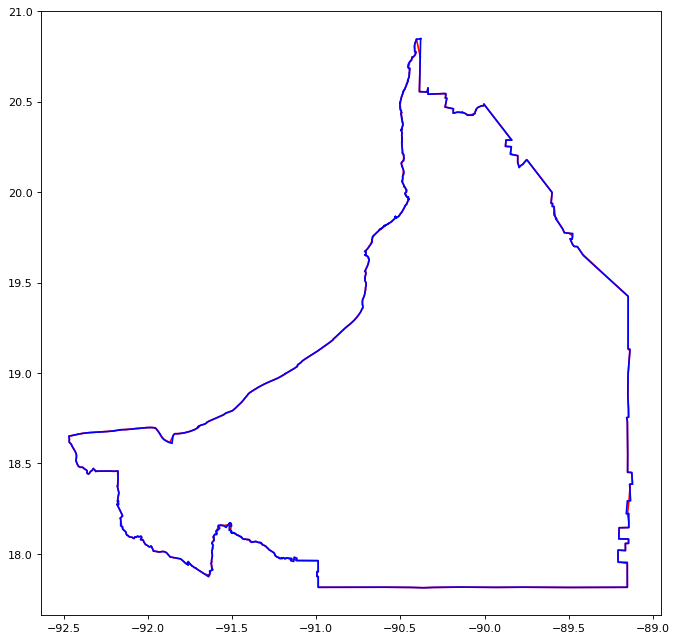

Clusters: 919 | %: 0.045481867830094204
4 : Cost:  9.785120588375143  | Límite:  84.0
9.785120588375143
No pasé por memCost


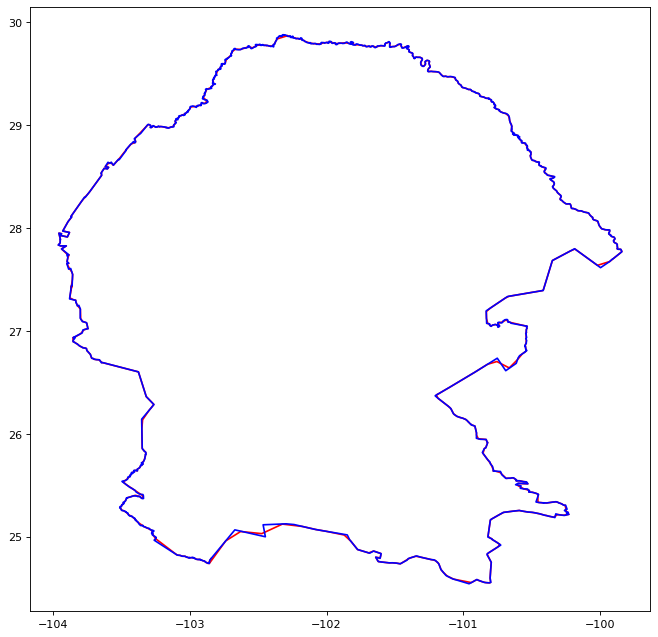

Clusters: 676 | %: 0.0832346508179488
5 : Cost:  21.608494874820344  | Límite:  56.0
21.608494874820344
No pasé por memCost


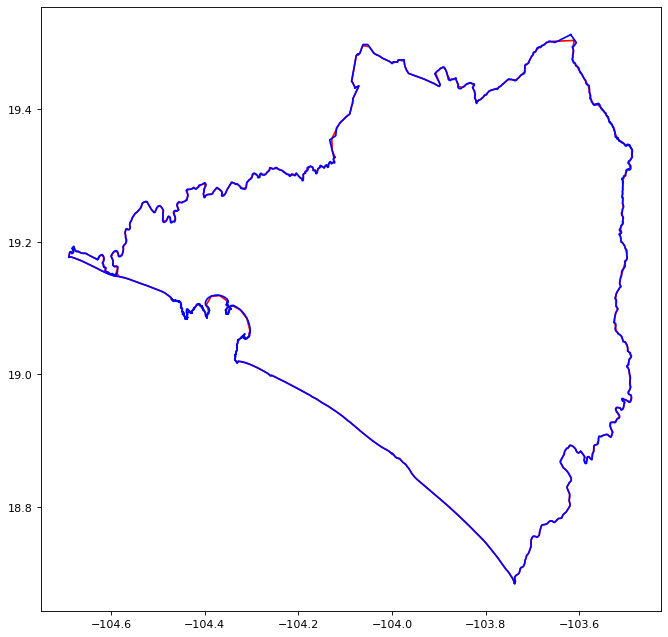

Clusters: 873 | %: 0.06129594785821249
6 : Cost:  10.92332763109233  | Límite:  72.0
10.92332763109233
No pasé por memCost


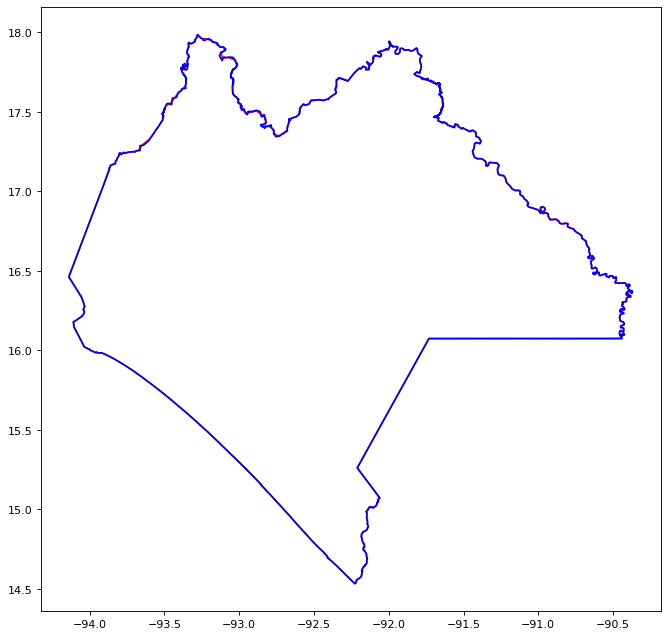

Clusters: 847 | %: 0.06541906549453941
7 : Cost:  10.383167010802076  | Límite:  69.0
10.383167010802076
No pasé por memCost


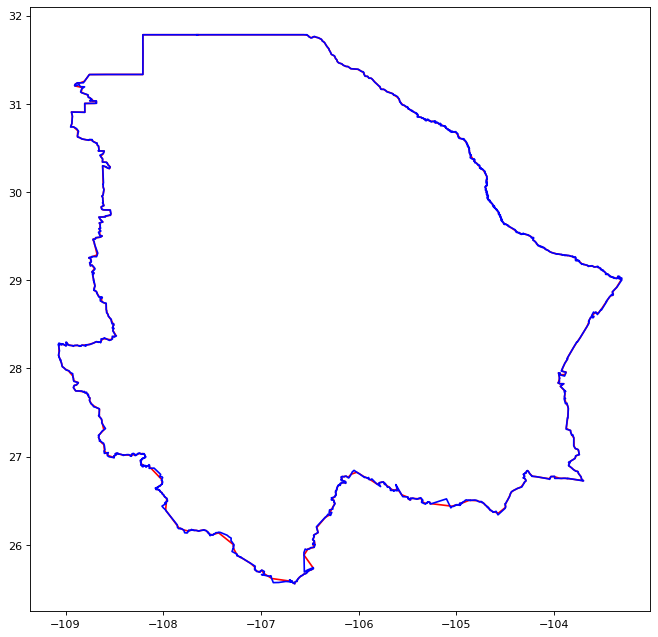

Clusters: 244 | %: 0.11206328286429391
8 : Cost:  10.977522980785734  | Límite:  31.0
10.977522980785734
No pasé por memCost


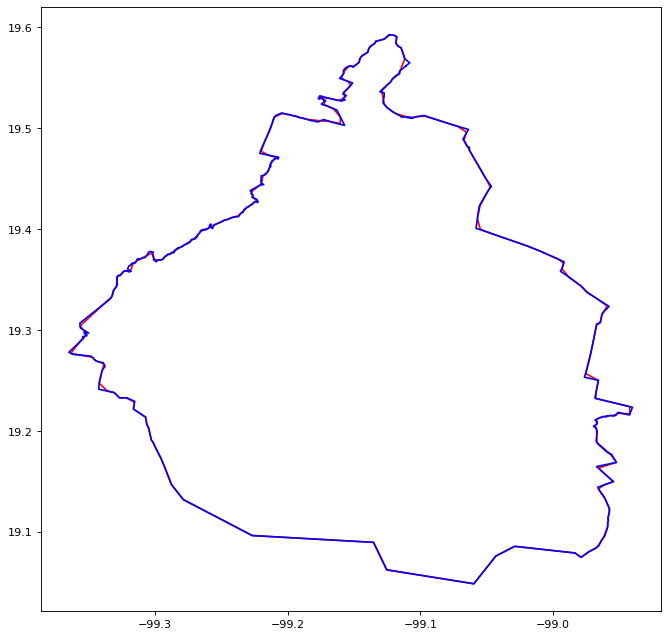

Clusters: 919 | %: 0.04635660280947015
9 : Cost:  20.425172258456477  | Límite:  83.0
20.425172258456477
No pasé por memCost


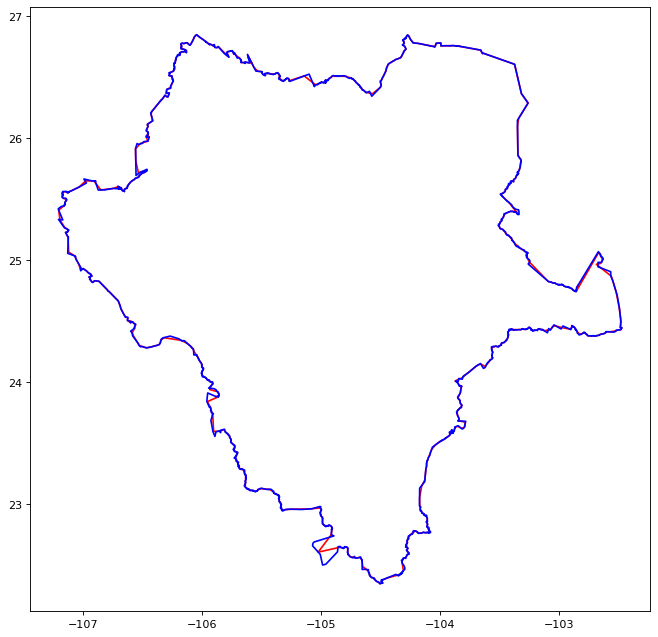

Clusters: 813 | %: 0.06974276845780954
10 : Cost:  9.515730997652527  | Límite:  66.0
9.515730997652527
No pasé por memCost


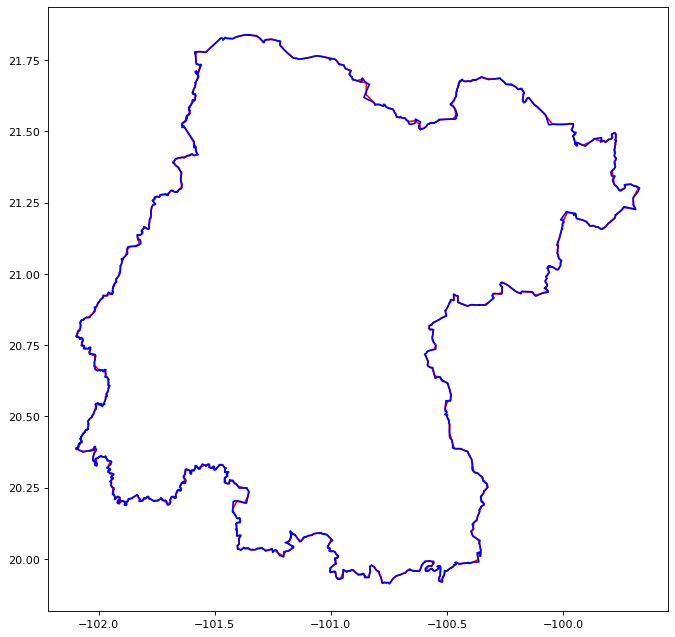

Clusters: 910 | %: 0.039524223507649836
11 : Cost:  135.69209115032442  | Límite:  89.0
11 : Cost:  120.15234005916219  | Límite:  89.0
11 : Cost:  141.24780924798364  | Límite:  89.0
11 : Cost:  115.31984513279352  | Límite:  89.0
11 : Cost:  131.68268498446946  | Límite:  89.0
11 : Cost:  128.6399772723567  | Límite:  89.0
11 : Cost:  128.15251021380467  | Límite:  89.0
11 : Cost:  146.92436350973315  | Límite:  89.0
11 : Cost:  122.67028449812167  | Límite:  89.0
11 : Cost:  116.07329259791324  | Límite:  89.0
11 : Cost:  136.7953977526356  | Límite:  89.0
11 : Cost:  128.4540529483398  | Límite:  89.0
11 : Cost:  135.3006768709286  | Límite:  89.0
11 : Cost:  146.33405152448867  | Límite:  89.0
11 : Cost:  119.0409057542577  | Límite:  89.0
11 : Cost:  131.45325662041415  | Límite:  89.0
11 : Cost:  141.4163448126071  | Límite:  89.0
11 : Cost:  131.4675873984608  | Límite:  89.0
11 : Cost:  127.96410831822715  | Límite:  89.0
11 : Cost:  121.88871602721815  | Límite:  89.0
115.319

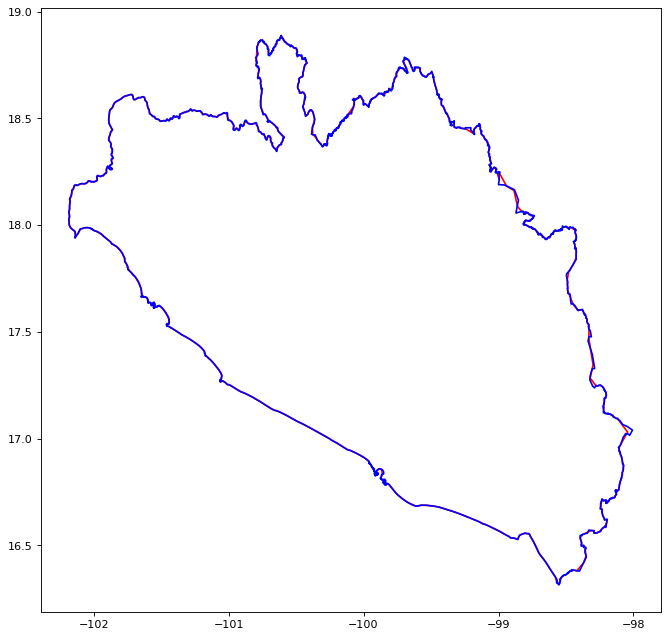

Clusters: 858 | %: 0.030270200214574893
12 : Cost:  748.5564094878108  | Límite:  98.0
12 : Cost:  73.37999689043097  | Límite:  98.0
73.37999689043097
No pasé por memCost


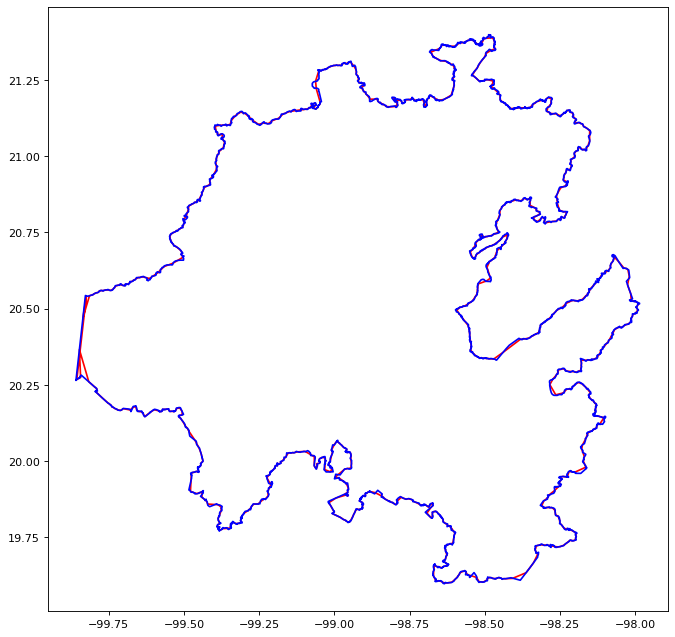

Clusters: 532 | %: 0.01090982475906679
13 : Cost:  32.125613169895665  | Límite:  125.0
32.125613169895665
No pasé por memCost


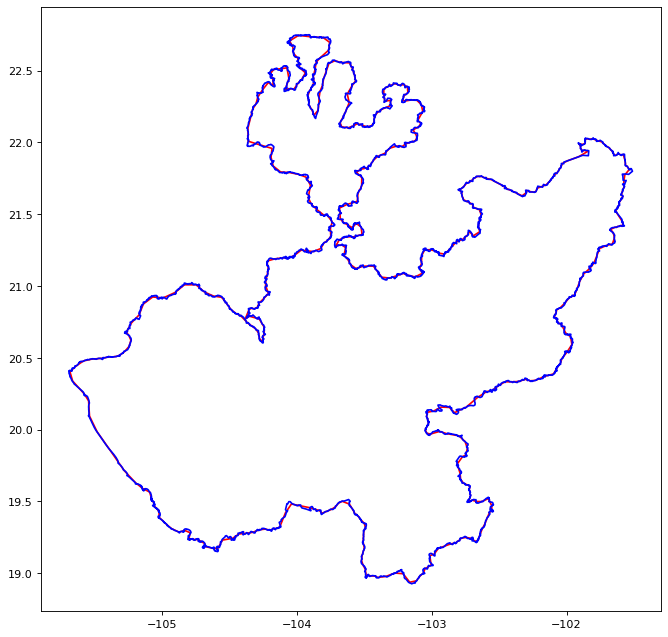

Clusters: 886 | %: 0.05888072204290049
14 : Cost:  26.784163549788133  | Límite:  74.0
26.784163549788133
No pasé por memCost


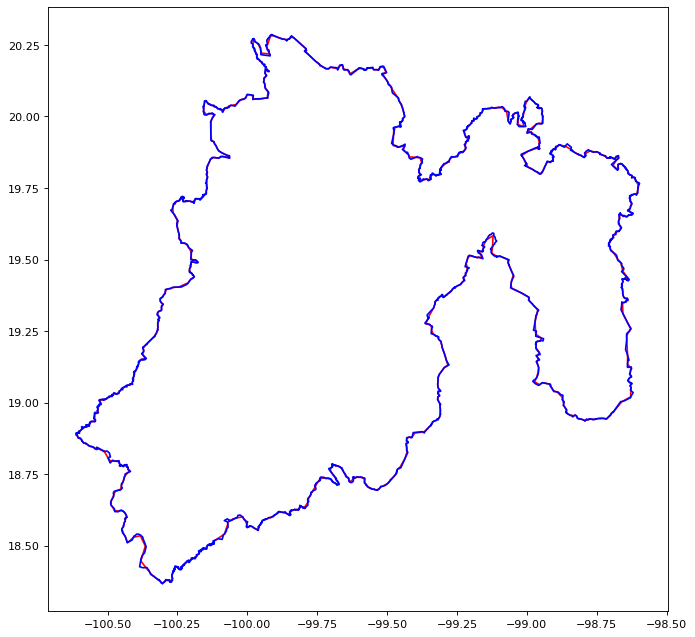

Clusters: 905 | %: 0.038088550962524205
15 : Cost:  20.02881045782774  | Límite:  91.0
20.02881045782774
No pasé por memCost


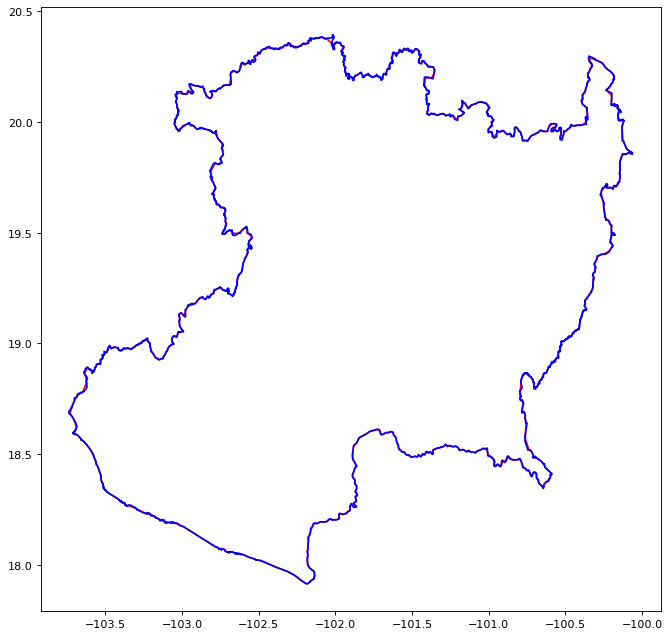

Clusters: 518 | %: 0.09520321738644054
16 : Cost:  17.0625125751695  | Límite:  47.0
17.0625125751695
No pasé por memCost


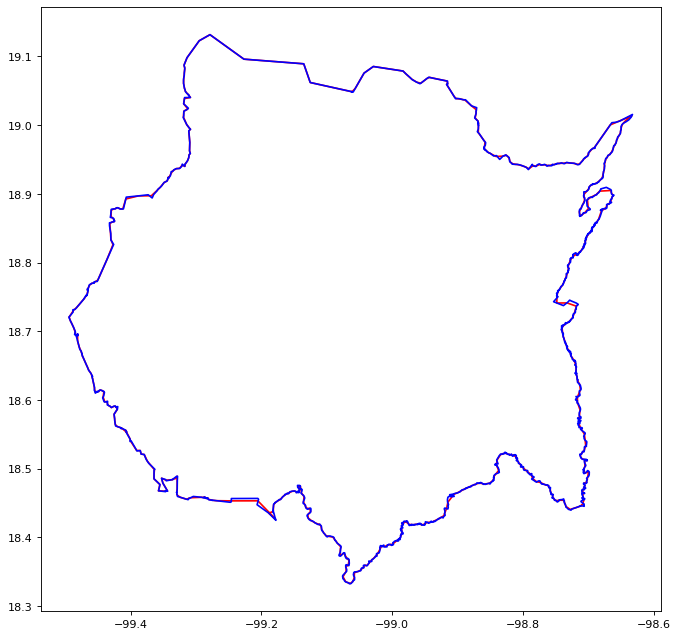

Clusters: 907 | %: 0.05361418814798945
17 : Cost:  238.54447312013414  | Límite:  78.0
17 : Cost:  36.374472578931304  | Límite:  78.0
36.374472578931304
No pasé por memCost


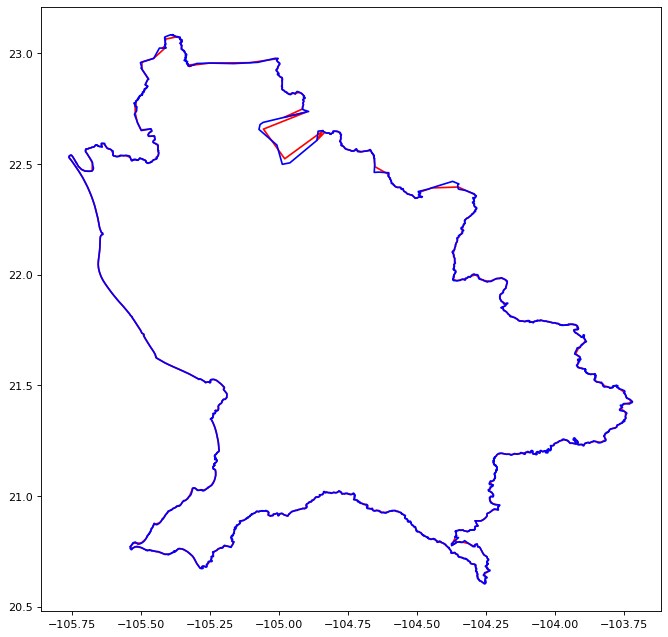

Clusters: 890 | %: 0.034885237215705286
18 : Cost:  18.601409191616256  | Límite:  93.0
18.601409191616256
No pasé por memCost


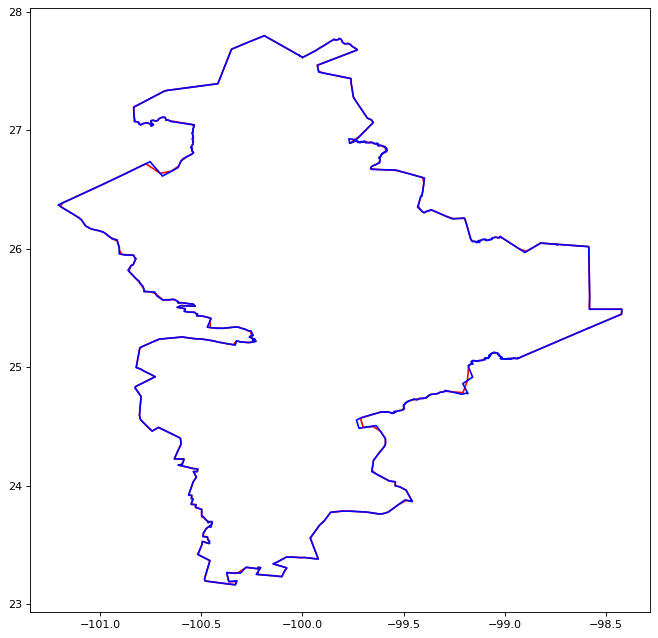

Clusters: 907 | %: 0.038708675084384594
19 : Cost:  25.46435406893506  | Límite:  90.0
25.46435406893506
No pasé por memCost


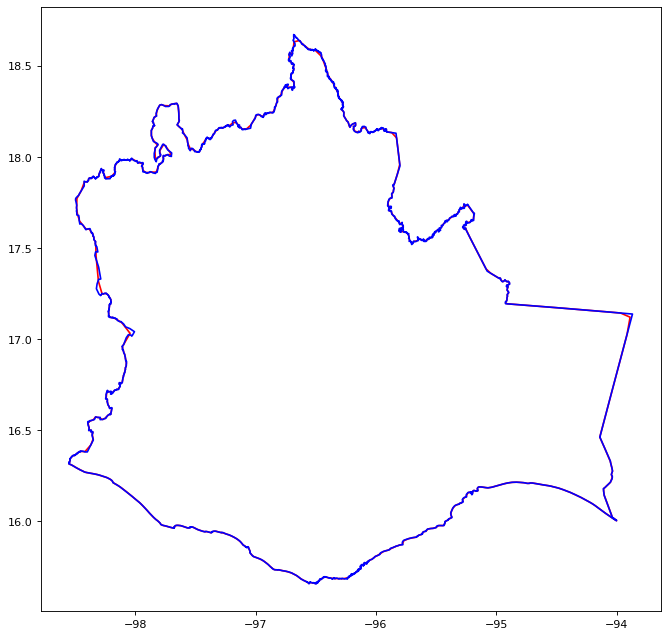

Clusters: 744 | %: 0.020723404988302337
20 : Cost:  49.77920222776536  | Límite:  109.0
49.77920222776536
No pasé por memCost


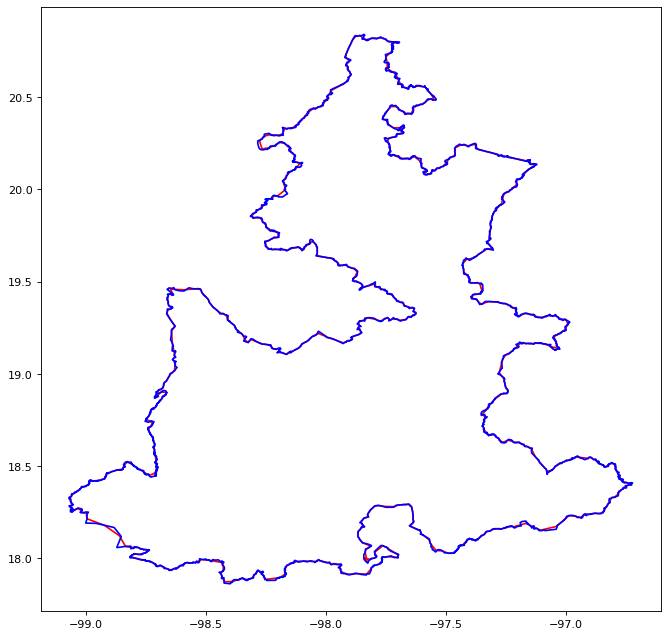

Clusters: 766 | %: 0.07492321111951625
21 : Cost:  52.361270797605464  | Límite:  62.0
52.361270797605464
No pasé por memCost


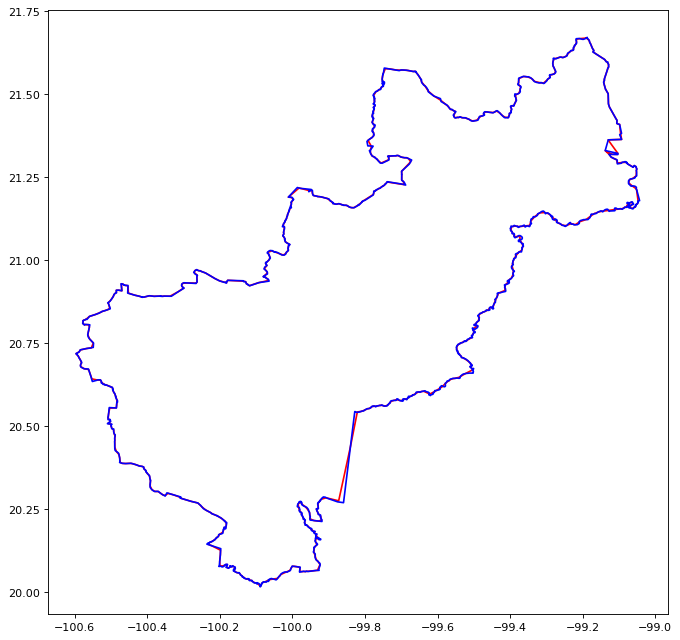

Clusters: 912 | %: 0.0516641303632321
22 : Cost:  12.039390785053293  | Límite:  79.0
12.039390785053293
No pasé por memCost


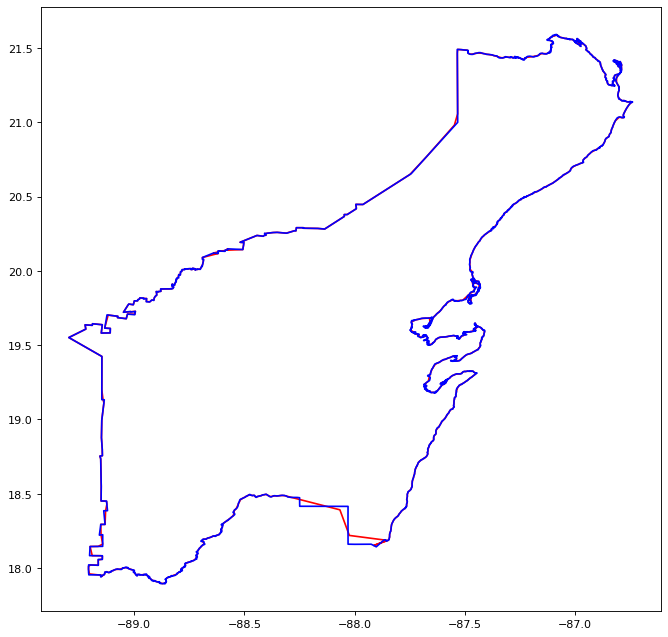

Clusters: 862 | %: 0.06317532118428808
23 : Cost:  19.992966003566412  | Límite:  71.0
19.992966003566412
No pasé por memCost


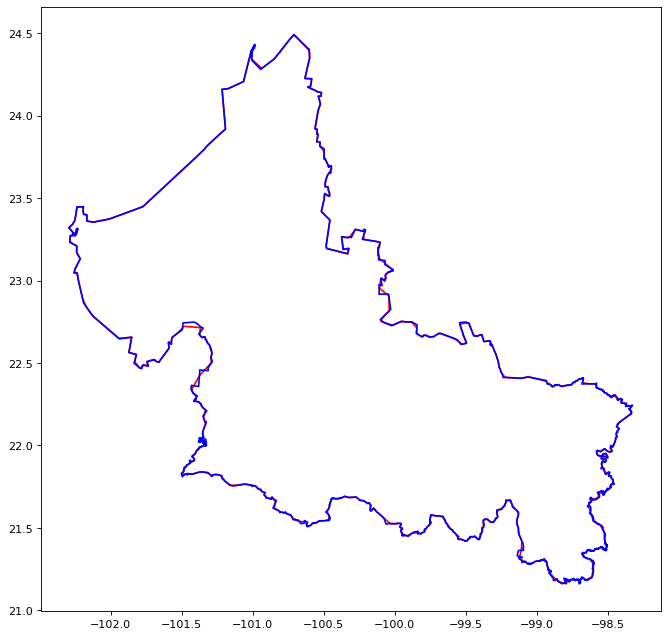

Clusters: 845 | %: 0.06569440337441766
24 : Cost:  24.958625037501484  | Límite:  69.0
24.958625037501484
No pasé por memCost


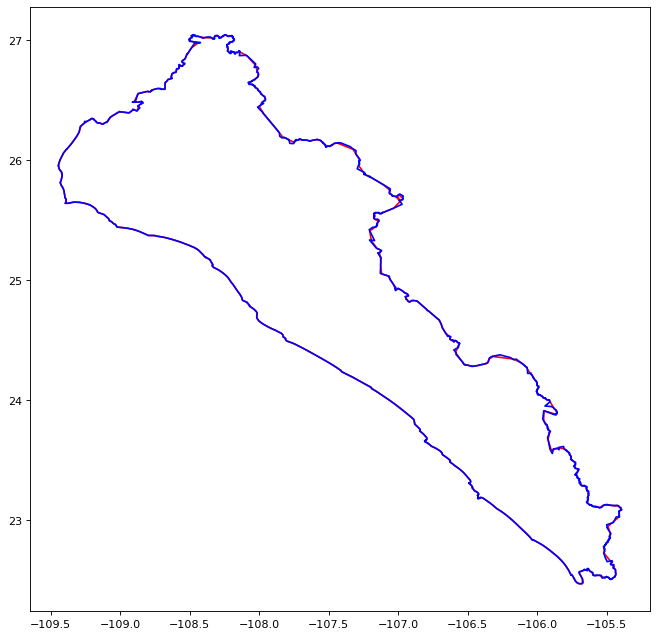

Clusters: 912 | %: 0.051938677160502
25 : Cost:  10.859509165355448  | Límite:  79.0
10.859509165355448
No pasé por memCost


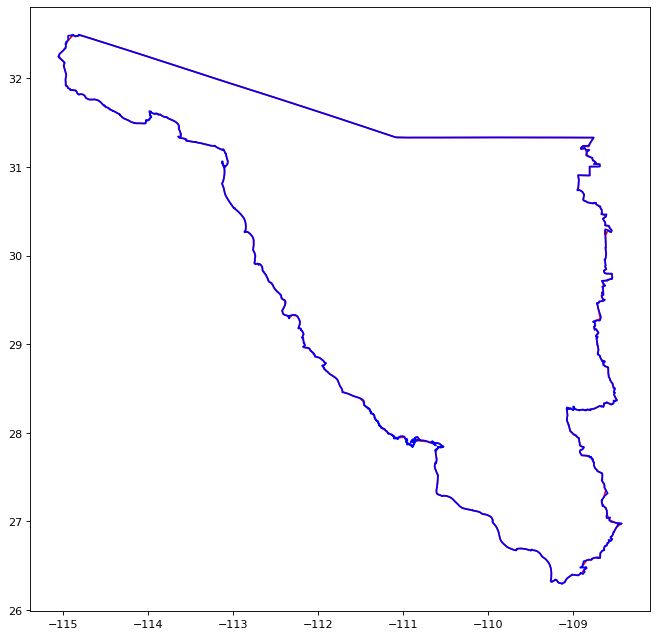

Clusters: 919 | %: 0.04635660280947015
26 : Cost:  24.48858838714223  | Límite:  83.0
24.48858838714223
No pasé por memCost


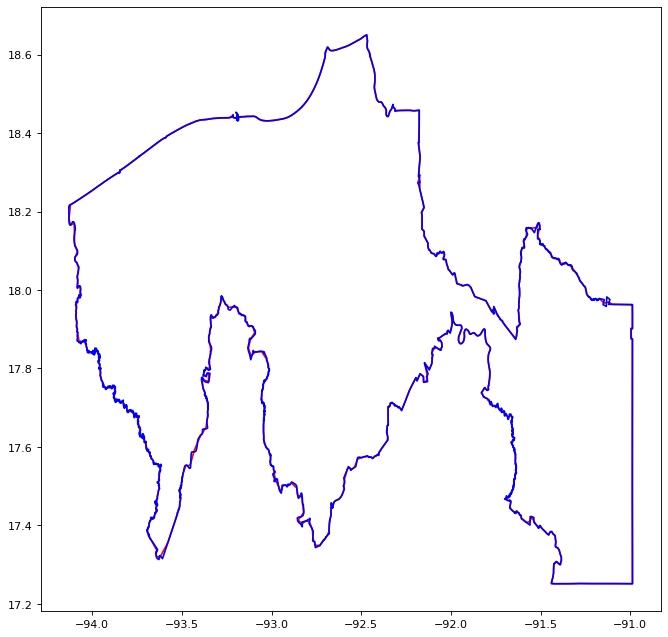

Clusters: 779 | %: 0.023026914727189044
27 : Cost:  11.38001782927308  | Límite:  106.0
11.38001782927308
No pasé por memCost


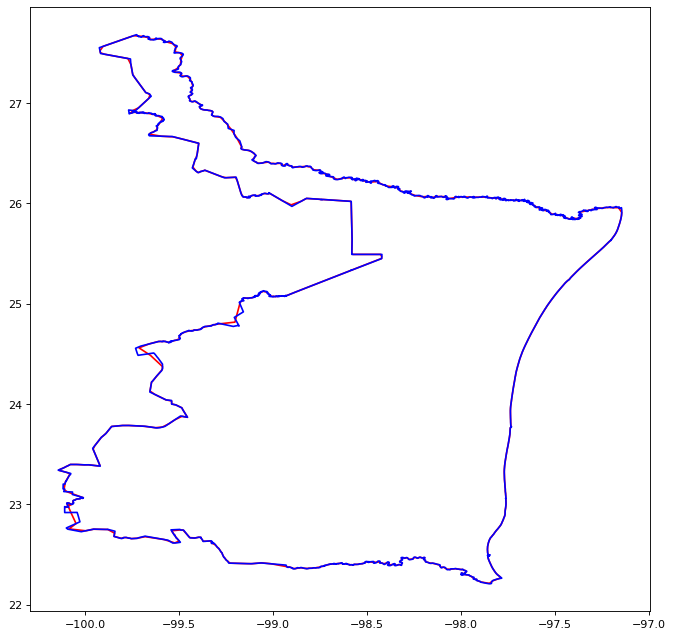

Clusters: 481 | %: 0.09773050457655819
28 : Cost:  21.610471501098434  | Límite:  45.0
21.610471501098434
No pasé por memCost


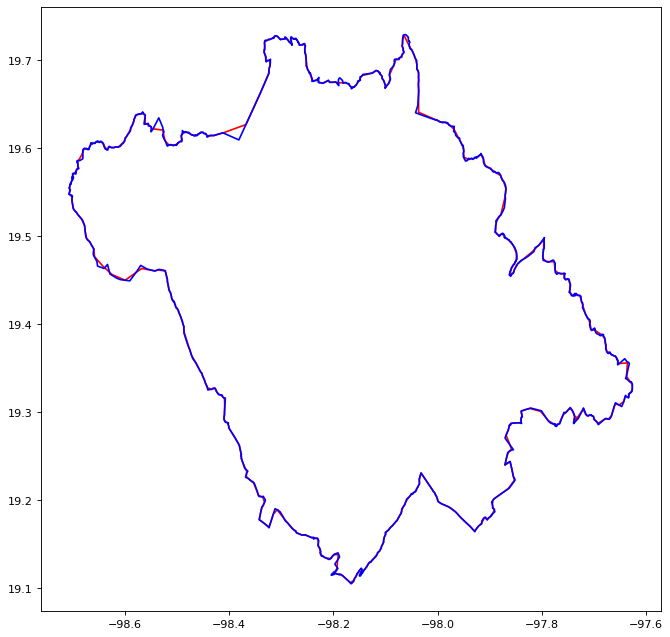

Clusters: 430 | %: 0.0077238561243531305
29 : Cost:  20.436085037523217  | Límite:  132.0
20.436085037523217
No pasé por memCost


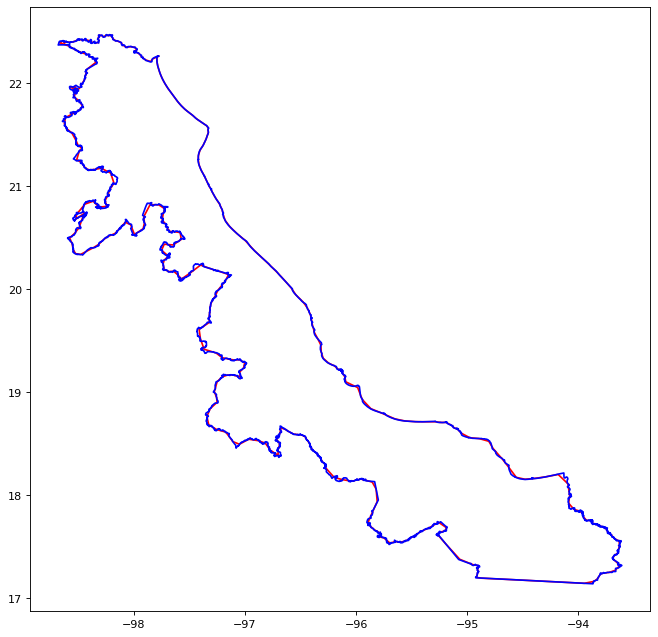

Clusters: 404 | %: 0.10264369685093293
30 : Cost:  35.1782280661469  | Límite:  41.0
35.1782280661469
No pasé por memCost


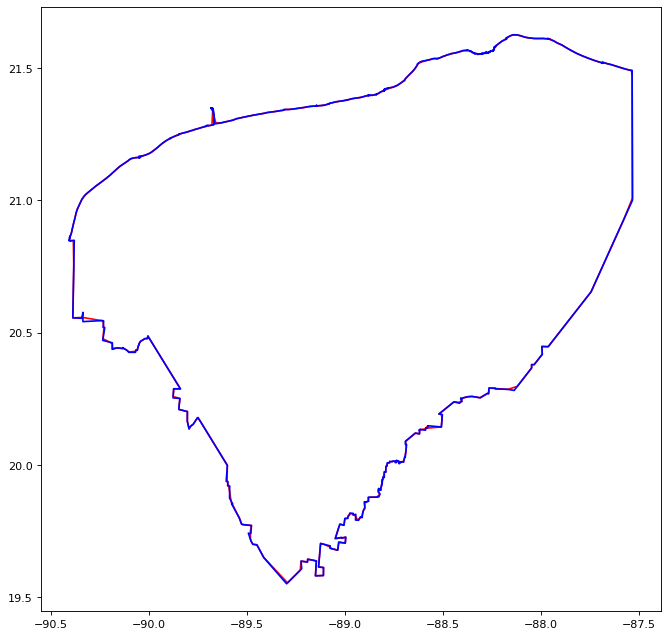

Clusters: 904 | %: 0.03798585058282845
31 : Cost:  24.79327125584085  | Límite:  91.0
24.79327125584085
No pasé por memCost


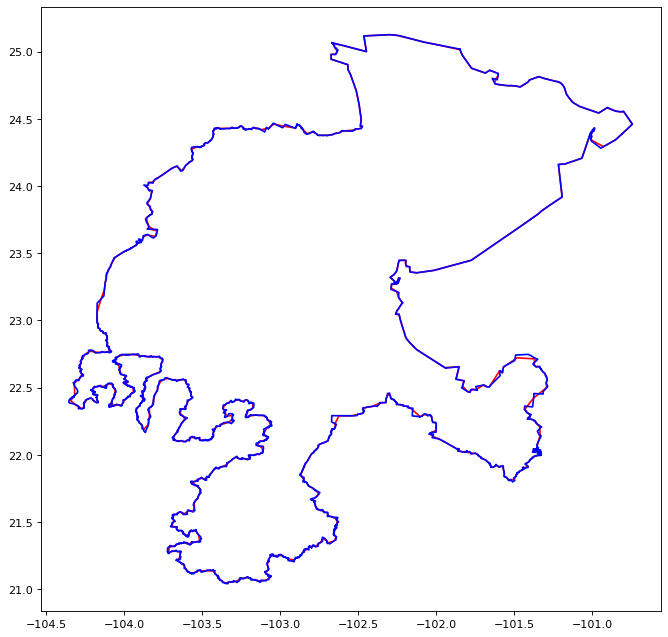

In [43]:
import numpy as np
import sklearn.cluster as clt
import matplotlib.pyplot as plt

entidades = len(jsEstados["features"])
divisiones = np.zeros(shape = (entidades))

for i in range(entidades):
    
    divisiones = jsEstados["features"][i]["geometry"]["coordinates"]
    
    posDiv, cantPunt = selectDivision(divisiones) # We use this function to select only the mainland of states.
    
    Estado = np.array(divisiones[posDiv][0]).T
    Estado = np.unique(Estado, axis=0)
    
    PMF = PMF_puntos(Estado)
    clusters = int(Estado.shape[1] * (np.exp((-1)*Estado.shape[1]/20000) / 8)) # The most points a state has, the least data we'll use as initial centroids
    
    print("Clusters: " + str(clusters) + " | " + "%: " + str(np.exp((-1)*Estado.shape[1]/20000) / 8))
    
    cost = 100
    limite = 0
    
    count = 0
    maxIter = 20
    
    memCost = np.zeros(shape=(maxIter), dtype=float)
    memData = [0,] * maxIter
    
    while (cost > limite) and (count < maxIter):
        
        index = promPMF(Estado, clusters, round(Estado[1].size * 0.1), PMF)
        
        kmEstado = clt.KMeans(n_clusters=clusters, init=Estado.T[index],
                              n_init=1, max_iter=50).fit(Estado.T)
        
        dataEstado = kmEstado.cluster_centers_ 
        
        dataEstado[-1] = dataEstado[0]
        
        cost = Cost_Func(dataEstado.T[1], Estado.T[index].T[1])
        
        memCost[count] = cost
        memData[count] = dataEstado
        
        limite = np.around(2.8 ** np.log10(Estado[0].size))
        
        print(i, ": Cost: ", cost, " | Límite: ", limite)
        count += 1
        
        
    if count >= maxIter:
        inx = np.where(memCost == memCost.min())[0][0]

        jsEstados2["features"][i]["geometry"]["coordinates"] = [[memData[inx].tolist()]]
        print(memCost.min())
        print("Pasé por el memCost")
    else:
        jsEstados2["features"][i]["geometry"]["coordinates"] = [[dataEstado.tolist()]]
        print(cost)
        print("No pasé por memCost")
    
    #jsEstados2["features"][i]["geometry"]["coordinates"] = [[dataEstado.tolist()]]
     
    plt.figure(figsize=(10, 10), dpi=80)
    plt.plot(dataEstado.T[0], dataEstado.T[1],"r")
    plt.plot(Estado[0], Estado[1], "b")
    
    plt.show()
    
    #print(i, " ", len(jsEstados2["features"][i]["geometry"]["coordinates"]))


## Save GeoJSON reduced data

In [44]:
import json as js
import os  

EstadosLink = "CleanData"
os.makedirs(EstadosLink, exist_ok=True) 

with open(EstadosLink + "/EstadosGEO.json", 'w') as json_file:
  js.dump(jsEstados2, json_file)